In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
plt.style.use(['science', 'notebook'])
from openpyxl import load_workbook
import imageio
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import minimize
import pint
u = pint.UnitRegistry()
u.define('U = u.microGy * u.m**2 / u.hour = U')

Units for $U$

Load spreadsheets

In [2]:
def get_data_datasheet(file, sheet, skiprows, usecols, nrows, add_init=None):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy().ravel()
    idx = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    return arr, idx

def get_interp_datasheet_1D(file, sheet, skiprows, usecols, nrows, add_init=None, scale=1):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy().ravel()/scale
    idx = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    if add_init:
        idx = np.insert(idx,0,add_init[0])
        arr = np.insert(arr,0,add_init[1])
    #return interp1d(idx, arr, kind='linear', bounds_error=False, fill_value=(arr.ravel()[0], arr.ravel()[-1]))
    return np.vectorize(interp1d(idx, arr, kind='linear', bounds_error=False, fill_value='extrapolate'))

def get_data_datasheet_2D(file, sheet, skiprows, usecols, nrows, scale=1):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy()/scale
    idx1 = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[2], nrows=nrows[2], usecols=usecols[2]).to_numpy().ravel()
    idx2 = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    return arr, idx1, idx2

def get_interp_datasheet_2D(file, sheet, skiprows, usecols, nrows, scale=1):
    arr = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[0], nrows=nrows[0], usecols=usecols[0]).to_numpy()/scale
    idx1 = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[2], nrows=nrows[2], usecols=usecols[2]).to_numpy().ravel()
    idx2 = pd.read_excel(file, sheet_name=sheet, skiprows=skiprows[1], nrows=nrows[1], usecols=usecols[1]).to_numpy().ravel()
    return np.vectorize(interp2d(idx1, idx2, arr))


Get interpolation functions

In [3]:
%%capture
# Arguments: r
g_Ir_int = get_interp_datasheet_1D('DATA4.xlsm', 'Ir-192 HDR', skiprows=[7,7],
                                     usecols=['C', 'B'], nrows=[18,18])
# Arguments: theta, r
F_Ir_int = get_interp_datasheet_2D('DATA4.xlsm', 'Ir-192 HDR', skiprows=[29,29,28],
                                     usecols=['B:AV','A', 'B:AV'], nrows=[20,20,1])
# Arguments: r
g_Ir_LDR_int = get_interp_datasheet_1D('DATA4.xlsm', 'Ir-192 LDR', skiprows=[7,7],
                                     usecols=['C', 'B'], nrows=[17,17])
# Arguments: theta, r
F_Ir_LDR_int = get_interp_datasheet_2D('DATA4.xlsm', 'Ir-192 LDR', skiprows=[28,28,27],
                                     usecols=['B:AV','A', 'B:AV'], nrows=[14,14,1])
# Arguments: r
gp_Pd_int = get_interp_datasheet_1D('DATA4.xlsm', 'Pd-103', skiprows=[7,7],
                                     usecols=['B', 'A'], nrows=[20,20])
# Arguments: r
gl_Pd_int = get_interp_datasheet_1D('DATA4.xlsm', 'Pd-103', skiprows=[7,7],
                                     usecols=['E', 'D'], nrows=[20,20])
# Arguments: theta, r
F_Pd_int = get_interp_datasheet_2D('DATA4.xlsm', 'Pd-103', skiprows=[31,31,30],
                                     usecols=['B:U','A', 'B:U'], nrows=[13,13,1])
# Arguments: h, active length
PP_int = get_interp_datasheet_2D('DATA4.xlsm', 'PP Line', skiprows=[5,5,4],
                                     usecols=['J:O:','A', 'J:O'], nrows=[31,31,1])

# Question 1

## Part A

The ratio of dose deposited at time $t$ vs. the total dose deposited is

$$\frac{D(r,\theta,t)}{D(r,\theta,\infty)} = 1-e^{-\lambda t}$$

Setting this equal to 0.95 (95% dose deposited), we get

$$t=-\frac{1}{\lambda}\ln(0.05)$$

In [4]:
lam_I125 = 0.00049 * u.hour**-1
lam_P103 = 0.0017 * u.hour**-1

Get times

In [5]:
t_I125 = -1/lam_I125 * np.log(0.05)
t_P103 = -1/lam_P103 * np.log(0.05)
print(f'Time for I125: {t_I125.to(u.day):.2f}')
print(f'Time for P103: {t_P103.to(u.day):.2f}')

Time for I125: 254.74 day
Time for P103: 73.42 day


## Part B

Since $D(t) = D(\infty) (1-e^{-\lambda t})$ we get

$$\dot{D}(t) = D(\infty)\lambda e^{-\lambda t}$$

At the 120% isodose we have

$$D(\infty)  = 1.2 \cdot \text{Prescribed Dose}$$

In [6]:
lam_Cs131 = np.log(2)/(9.7*u.day)
lam_Cs131 = lam_Cs131.to(u.hour**-1).magnitude

Get prescribed doses and $\lambda$s for each dose plan

In [7]:
PDs = np.array([145, 125, 115])*u.Gy
lams = np.array([0.00049, 0.0017, lam_Cs131]) * u.hour**-1
t = np.linspace(0, 100, 100)*u.day

Get dose rates

In [8]:
Ds = [1.2*PD*lam*np.exp(-lam*t) for PD, lam in zip(PDs, lams)]
Ds = [D.to(u.cGy/u.hour) for D in Ds]

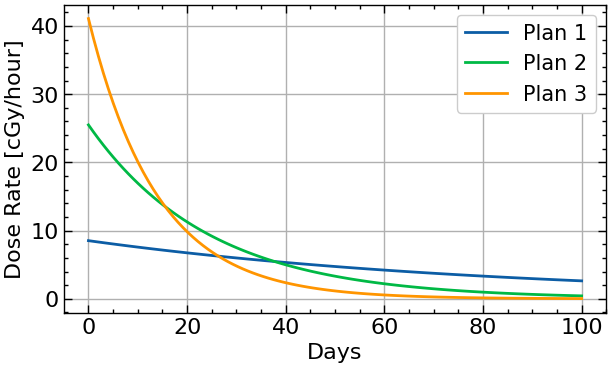

In [9]:
plt.figure(figsize=(7,4))
plt.plot(t.magnitude, Ds[0].magnitude, label='Plan 1')
plt.plot(t.magnitude, Ds[1].magnitude, label='Plan 2')
plt.plot(t.magnitude, Ds[2].magnitude, label='Plan 3')
plt.ylabel('Dose Rate [cGy/hour]')
plt.xlabel('Days')
plt.grid()
plt.legend(fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.show()

## Part C

The time to resolution of acute urinary morbitity could be modeled as a lag time $t_0$ after the dose rate falls below a dose rate threshhold of $\dot{D}_0$. In the plot above, although Plan 3 starts with the largest dose rate, it also reaches smaller dose rates faster. In some cases, it may be worthwhile having a plan that starts with a higher dose rate at earlier times as long as it falls below the dose rate threshhold $\dot{D}_0$ faster than other plans. Since the toxicity symptoms are acute, this is a reasonable model.

# Question 2

For all questions, we will need the angle $\beta$. This is given by

$$\beta = \tan^{-1}\left(\frac{r\sin\theta}{r\cos\theta-L/2}\right) - \tan^{-1}\left(\frac{r\sin\theta}{r\cos\theta+L/2}\right)$$

In [10]:
def Beta(r, theta, L):
    return np.arctan2(L/2 - r*np.cos(theta), r*np.sin(theta)) \
          - np.arctan2(-L/2 - r*np.cos(theta), r*np.sin(theta))

def GL(r, theta, L, eps=1e-5):
    return Beta(r, theta+eps, L) / (L*r*np.sin(theta+eps))

## Part A

Using 

$$D(r,\theta,t) = \frac{S_{K_0}}{\lambda} \Lambda (1-e^{-\lambda t}) \frac{G_L(r,\theta)}{G_L(r_0, \theta_0)}g_L(r)F(r,\theta)$$

we get

$$(1-e^{-\lambda t}) = D \cdot \left( \frac{S_{K_0}}{\lambda} \Lambda \frac{G_L(r,\theta)}{G_L(r_0, \theta_0)}g_L(r)F(r,\theta) \right)^{-1} \equiv P$$

so 

$$t = -\frac{1}{\lambda}\ln(1-P)$$

Define all parameters

In [11]:
A = 10*u.Ci
Gam = 4.03 * u.U / u.mCi
lam = 0.00039 / u.hour
Lam = 1.11 * u.cGy / u.hour / u.U
SK0 = A * Gam
L = 0.36*u.cm
r0 = 1 * u.cm
rQ = 3*u.cm
rA = 2*u.cm
rB = 3*u.cm
rC = 3*u.cm
the0 = np.pi/2
theQ = np.pi/2
theA = np.pi/2
theB = 0
theC = 10 * np.pi/180
D = 3.4 * u.Gy

Calculate $P$ (defined above)

In [12]:
P = D * (SK0 * Lam / lam * GL(rQ,theQ,L)/GL(r0,the0,L) \
    * g_Ir_int(rQ.to('cm').magnitude) \
    * F_Ir_int(theQ*180/np.pi, rQ.to('cm').magnitude))**-1
P = P.to_base_units()

Calculate $t$

In [13]:
t = -1/lam * np.log(1-P)
print(f'Time Required: {t.to(u.min)[0]:.2f}')

Time Required: 4.03 minute


## Part B

The only thing that changes here is the initial activity of the source, which decays exponentially. 

* First day is 29 days after calibration
* Last treatment is on a Tuesday 13 days after the initial day

In [14]:
A_first = A * np.exp(-lam * 29*u.day)
A_last = A * np.exp(-lam * 42*u.day)

Function to compute time given initial activity $A$ at time of treatment

In [15]:
def compute_time(A):
    P = D * (A*Gam * Lam / lam * GL(rQ,theQ,L)/GL(r0,the0,L) \
        * g_Ir_int(rQ.to('cm').magnitude) \
        * F_Ir_int(theQ*180/np.pi, rQ.to('cm').magnitude))**-1
    P = P.to_base_units()
    return -1/lam * np.log(1-P)

Print times required

In [16]:
print(f'Time for first fraction: {compute_time(A_first).to(u.min)[0]:.2f}')

Time for first fraction: 5.29 minute


In [17]:
print(f'Time for last fraction: {compute_time(A_last).to(u.min)[0]:.2f}')

Time for last fraction: 5.98 minute


To get the TRAK, we use

In [18]:
def TRAK(A):
    t = compute_time(A)[0]
    return A*Gam/lam * (1-np.exp(-lam*t))

print(f'TRAK Fraction 1: {TRAK(A_first).to(u.U*u.s):.2e}')
print(f'TRAK Fraction 10: {TRAK(A_last).to(u.U*u.s):.2e}')

TRAK Fraction 1: 9.75e+06 U * second
TRAK Fraction 10: 9.75e+06 U * second


Note that the TRAK is the same for both

## Part C

The dose can be written as 

$$D(r,\theta,t) = \frac{S_{K_0}}{\lambda} \Lambda \frac{G_L(r,\theta)}{G_L(r_0, \theta_0)}g_L(r)F(r,\theta) \cdot h(t)$$

where $h(t)$ is some function of $t$, so we have

$$\frac{D_i}{D_Q} = \frac{G_L(r_i,\theta_i)}{G_L(r_Q,\theta_Q)} \frac{g_L(r_i)}{g_L(r_Q)} \frac{F(r_i,\theta_i)}{F(r_Q,\theta_Q)}$$

In [19]:
def compute_Di(rQ, theQ, ri, thei, DQ):
    return DQ * GL(ri, thei, L)/GL(rQ, theQ, L) \
              * g_Ir_int(ri.to('cm').magnitude) / g_Ir_int(rQ.to('cm').magnitude) \
              * F_Ir_int(thei*180/np.pi, ri.to('cm').magnitude) / F_Ir_int(theQ*180/np.pi, rQ.to('cm').magnitude)

Print corresponding doses:

In [20]:
print(f'Dose to A: {compute_Di(rQ, theQ, rA, theA, 34*u.Gy)[0].magnitude:.2f} Gy')
print(f'Dose to B: {compute_Di(rQ, theQ, rB, theB, 34*u.Gy)[0].magnitude:.2f} Gy')
print(f'Dose to C: {compute_Di(rQ, theQ, rC, theC, 34*u.Gy)[0].magnitude:.2f} Gy')

Dose to A: 76.16 Gy
Dose to B: 22.21 Gy
Dose to C: 26.30 Gy


# Question 3

## Part A

Like in the previous problem, for each source we have

$$D(r_i,\theta_i,t) = \frac{S_{K_0}}{\lambda} \Lambda (1-e^{-\lambda t}) \frac{G_L(r_i,\theta_i)}{G_L(r_0, \theta_0)}g_L(r_i)F(r_i,\theta_i)$$

So the total dose is

$$D = \left(\sum_{i=1}^5 \frac{S_{K_0}}{\lambda} \Lambda \frac{G_L(r_i,\theta_i)}{G_L(r_0, \theta_0)}g_L(r_i)F(r_i,\theta_i) \right)  (1-e^{-\lambda t}) $$

we get

$$(1-e^{-\lambda t}) = D \cdot \left(\sum_{i=1}^5 \frac{S_{K_0}}{\lambda} \Lambda \frac{G_L(r_i,\theta_i)}{G_L(r_0, \theta_0)}g_L(r_i)F(r_i,\theta_i) \right)^{-1} \equiv P$$

so 

$$t = -\frac{1}{\lambda}\ln(1-P)$$

The values of $r_i$ and $\theta_i$ are given by the diagram below

Define all values

In [21]:
A = 3*u.mCi
Gam = 4.03 * u.U / u.mCi
lam = 0.00039 / u.hour
Lam = 1.11 * u.cGy / u.hour / u.U
SK0 = A * Gam
L = 0.3*u.cm
xs = np.array([2, 1, 0, 1, 2]) * u.cm
y = 2 * u.cm
thetas = np.arctan(xs/y)
rs = np.sqrt(xs**2+y**2)
D = 3.4 * u.Gy

The function below computes one of the terms

$$\frac{S_{K_0}}{\lambda} \Lambda \frac{G_L(r_i,\theta_i)}{G_L(r_0, \theta_0)}g_L(r_i)F(r_i,\theta_i)$$

In [22]:
def compute_sum_term(r, the, g, F, r0=1*u.cm, the0=np.pi/2):
    return SK0 * Lam / lam * GL(r,the,L)/GL(r0,the0,L) \
               * g(r.to('cm').magnitude) \
               * F(the, r.to('cm').magnitude)

This is used to compute $P$:

In [23]:
P = D * sum(compute_sum_term(rs, thetas, g_Ir_LDR_int, F_Ir_LDR_int))**-1

C:\Users\lukep\anaconda3\lib\site-packages\numpy\lib\function_base.py:2195: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  args = [asarray(arg) for arg in args]
C:\Users\lukep\anaconda3\lib\site-packages\numpy\lib\function_base.py:2244: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  inputs = [asanyarray(a, dtype=object) for a in args]


and then to get $t$:

In [24]:
t = -1/lam * np.log(1-P)
print(f'Time Required: {t.to(u.hour):.2f}')

Time Required: 40.84 hour


## Part B

We know the the amount of dose administered is proportional to the amount of activity times time

$$\frac{D_{X\%}}{D_{100\%}} = \frac{A_X \cdot t_X}{A_{100\%} \cdot t_{100\%}}$$

The Paterson parkers given $N(h_X)$ such that $N(h_X) \cdot A \cdot t = 10~$Gy. Thus $A \cdot t \propto N^{-1}$ and 

$$\frac{D_{X\%}}{D_{100\%}} = \frac{N(h_{100\%})}{N(h_{X\%})}$$

we want to find the distances $h_{X\%}$ such that the fraction on the right equals either 200% or 56%. We do this by minimizing the objective function 

$$\left|\frac{D_{X\%}}{D_{100\%}} - \frac{N(h_{100\%})}{N(h_{X\%})}\right|$$

with respect to $h_{X\%}$

In [25]:
def min_func(h, percent=100):
    return np.abs(percent - 100* PP_int(2, L.magnitude) \
                                /PP_int(h, L.magnitude))

Get values

In [26]:
%%capture
h_200 = minimize(min_func, x0=1, args=(200), method='Nelder-Mead').x[0]
h_56 = minimize(min_func, x0=1, args=(56), method='Nelder-Mead').x[0]

In [27]:
print(f'Distance corresponding to 200% isodose line: {h_200:.5f} cm')
print(f'Distance corresponding to 56% isodose line: {h_56:.5f} cm')

Distance corresponding to 200% isodose line: 1.39510 cm
Distance corresponding to 56% isodose line: 2.66256 cm


Get relative differences to true values to determine how well Paterson-Parker tables predict these values

In [28]:
PD200 = np.abs(h_200 - 1.23)/1.23 * 100
PD56 = np.abs(h_56 - 2.92)/2.92 * 100

In [29]:
print(f'Percent Difference (distance) of 200% isodose line: {PD200:.5f}%')
print(f'Percent Difference (distance) of 56% isodose line: {PD56:.5f} %')

Percent Difference (distance) of 200% isodose line: 13.42317%
Percent Difference (distance) of 56% isodose line: 8.81640 %


The percent differences with the actual distances is on the order of 10%. For the scaling of this particular problem, this corresponds to errors on the order of a few millimeters.

# Question 4

Define $G_P$

In [30]:
def GP(r):
    return 1/r**2

Define parameters

In [31]:
r = np.arange(0.2, 2.2, 0.01)
r0 = 1
the0 = np.pi/2
L = 0.423

Obtain quantities

In [32]:
QA = GP(r)/GP(1) * gp_Pd_int(r)
QB = GL(r, 0, L)/GL(r0, the0, L) * gl_Pd_int(r)
QC = GL(r, np.pi/2, L)/GL(r0, the0, L) * gl_Pd_int(r)

Plot

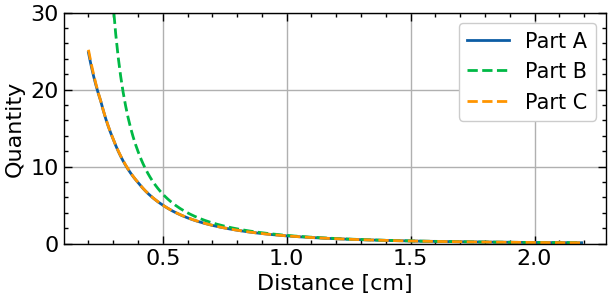

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(7,3))
ax.plot(r, QA, label='Part A') 
ax.plot(r, QB, ls='--', label='Part B') 
ax.plot(r, QC, ls='--', label='Part C') 
ax.set_xlabel('Distance [cm]')
ax.set_ylabel('Quantity')
ax.grid()
ax.set_ylim(top=30, bottom=0)
plt.legend(fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.show()

The reason that quantity $B$ blows up at 0.2cm is because the location $(r,\theta)=(0.2,0)$ is located inside the line source.

# Question 5

## Part A

We have

* $(r_c, \theta_c) = (6.9~\text{mm}, \pi/2)$
* $(r_e, \theta_e) = (\sqrt{5^2+6.5^2}~\text{mm}, \pi/2)$

where $c$ referes to center seed and $e$ refers to outer seed. Now the dose from the $ith$ seed is given by

$$D_i(r_i,\theta_i,t) = \frac{S_{K_0}}{\lambda} \Lambda (1-e^{-\lambda t}) \frac{G_L(r_i,\theta_i)}{G_L(r_0, \theta_0)}g_L(r_i)F(r_i,\theta_i)$$

From the above

$$D_{tot} = \frac{S_{K_0}}{\lambda} \Lambda (1-e^{-\lambda t}) \frac{G_L(r_c,\theta_c)}{G_L(r_0, \theta_0)}g_L(r_c)F(r_c,\theta_c) + 8 \cdot\frac{S_{K_0}}{\lambda} \Lambda (1-e^{-\lambda t}) \frac{G_L(r_e,\theta_e)}{G_L(r_0, \theta_0)}g_L(r_e)F(r_e,\theta_i)$$

so

$$S_{K_0} = D_{tot} \frac{\lambda}{\Lambda} \left(1-e^{-\lambda t} \right)^{-1} \left(\frac{G_L(r_c,\theta_c)}{G_L(r_0, \theta_0)}g_L(r_c)F(r_c,\theta_c) + 8 \cdot\frac{G_L(r_e,\theta_e)}{G_L(r_0, \theta_0)}g_L(r_e)F(r_e,\theta_i) \right)^{-1}$$

In [45]:
rc = 6.9 * u.mm
re = np.sqrt(5**2 + 6.5**2) * u.mm
L = 4.23 * u.mm
t = 168*u.hour
D = 70*u.Gy
lam = 0.0017 * u.hour**-1
Lam = 0.686 * u.cGy / u.hour / u.U
the = the0 = np.pi/2

Function for computing positional factors

In [46]:
def pos_factor_line(G, g, F, r, the, L, r0=1*u.cm, the0=np.pi/2):
    return G(r,the,L)/G(r0,the0,L) * g(r.to(u.cm).magnitude) \
            * F(the*180/np.pi, rc.to(u.cm).magnitude)
def pos_factor_point(G, g, F, r, the, L, r0=1*u.cm, the0=np.pi/2):
    return G(r)/G(r0) * g(r.to(u.cm).magnitude) \
            * F(the*180/np.pi, r.to(u.cm).magnitude)

Compute $S_{K_0}$, firstly using the line convention (taking into account finite length of the seeds) and secondly using point convention

In [47]:
SK0_line  = D * lam/Lam * (1-np.exp(-lam*t))**-1 \
        * (pos_factor_line(GL, gl_Pd_int, F_Pd_int, rc, the, L) \
          +8*pos_factor_line(GL, gl_Pd_int, F_Pd_int, re, the, L))**-1
print(f'Line Convention: Air Kerma Strength for each seed: {SK0_line.to(u.U)[0]:.4f}')

Line Convention: Air Kerma Strength for each seed: 4.4926 U


In [48]:
SK0_point  = D * lam/Lam * (1-np.exp(-lam*t))**-1 \
        * (pos_factor_point(GP, gp_Pd_int, F_Pd_int, rc, the, L) \
          +8*pos_factor_point(GP, gp_Pd_int, F_Pd_int, re, the, L))**-1
print(f'Point Convention: Air Kerma Strength for each seed: {SK0_point.to(u.U)[0]:.4f}')

Point Convention: Air Kerma Strength for each seed: 4.5010 U


## Part B

Like in electricity&magnetism, where a line charge becomes an effective monopole at large enough distances, so too does the line of activity in these problems. Note

$$G_L(r,\pi/2) = \frac{\beta}{rL} = \frac{2\tan^{-1}(L/2r)}{rL}$$

For $L/r << 1$, this reduces to 

$$G_L(r,\pi/2) \approx \frac{2 \cdot L/2r}{rL} = \frac{1}{r^2} = G_P(r)$$

Since $\tan^{-1}$ is odd (meaning that its Taylor expansion consists of only odd terms), the requirement that $L/2r << 1$ for $\tan^{-1}(L/2r) \approx L/2r$ is less strict than for functions containing even and odd components. In this particular problem,

In [49]:
pct_diff_edge = 100* np.abs(np.arctan(L/(2*re)).magnitude - L/(2*re)) \
                / (np.arctan(L/(2*re)).magnitude)
pct_diff_center = 100 * np.abs(np.arctan(L/(2*rc)).magnitude - L/(2*rc)) \
                / (np.arctan(L/(2*rc)).magnitude)
print(f'Percent difference (edge sources): {pct_diff_edge.magnitude:.2f}%')
print(f'Percent difference (center source): {pct_diff_center.magnitude:.2f}%')

Percent difference (edge sources): 2.18%
Percent difference (center source): 3.06%


The percent differences between $G_L$ and $G_P$ are small enough (less than 5%) to warrant using $G_P$ instead of $G_L$

The analysis above, however, does not consider the affects of $g_P$ vs $g_L$. But when considering the plot in Question 4, we see that plotting quantity $A$ and quantity $C$, yields two overlapping curves. This suggests that scatter effects ($g_p$ and $g_L$) for the line sources reduce to those for the point source at the distance scale considered for the sources in this problem. Furthermore, most importantly, it suggests that the entire position dependent factor reduces:

$$\frac{G_P(r)}{G_P(r_0)} g_P(r) \approx \frac{G_L(r,\pi/2)}{G_L(r_0,\pi/2)}g_L(r)$$

meaning that the point source and line source formalism is usable in both scenarios for the distance scale considered (not that all $r$ values used in this problem are greater than 0.2mm, the minimum $x$-axis value in the plot of question 4).

## Part C

Since 

$$S_{K_0} \propto \frac{1}{1-e^{-\lambda t}}$$

we have

$$\frac{S_{K_0}^{(2)}}{S_{K_0}^{(1)}} = \frac{1-e^{-\lambda t_1}}{1-e^{-\lambda t_2}}$$

If the source strength is 6% higher than measured then it follows that $\frac{S_{K_0}^{(2)}}{S_{K_0}^{(1)}} = 1.06$ and after some algebra:

$$t_2 = -\frac{1}{\lambda} \ln \left(1-1.06^{-1}(1-e^{-\lambda t_1}) \right)$$

In [39]:
t2 = -1/lam * np.log(1-1/1.06*(1-np.exp(-lam*t)))
print(f'New time required: {t2:.2f}')

New time required: 157.10 hour


The dose given at 5mm height without taking into account this correction is $1.06 \cdot 70$Gy $=74.2$Gy. Now nothing that 

$$D \propto \frac{G_L(r_c,\theta_c)}{G_L(r_0, \theta_0)}g_L(r_c)F(r_c,\theta_c) + 8 \cdot\frac{G_L(r_e,\theta_e)}{G_L(r_0, \theta_0)}g_L(r_e)F(r_e,\theta_i)$$

we look for the value of $r$ that makes

$$\frac{70}{74.2} = \frac{1}{1.06} = \frac{\frac{G_L(r_c^{\text{new}},\theta_c)}{G_L(r_0, \theta_0)}g_L(r_c^{\text{new}})F(r_c^{\text{new}},\theta_c) + 8 \cdot\frac{G_L(r_e^{\text{new}},\theta_e)}{G_L(r_0, \theta_0)}g_L(r_e^{\text{new}})F(r_e^{\text{new}},\theta_i)}{\frac{G_L(r_c,\theta_c)}{G_L(r_0, \theta_0)}g_L(r_c)F(r_c,\theta_c) + 8 \cdot\frac{G_L(r_e,\theta_e)}{G_L(r_0, \theta_0)}g_L(r_e)F(r_e,\theta_i)}$$

where "new" is the new value of $r_c$ and $r_e$ at the proper height. Note that $r_c$ and $r_e$ both depend on the height:

* $r_c^{new} = h^{new}+1.9$
* $r_e^{new} = \sqrt{{h^{new}}^2 + 6.5^2}$

so we can minimize an objective function with respect to $h^{\text{new}}$ given by

$$\left|\frac{1}{1.06} - \frac{\frac{G_L(r_c^{\text{new}},\theta_c)}{G_L(r_0, \theta_0)}g_L(r_c^{\text{new}})F(r_c^{\text{new}},\theta_c) + 8 \cdot\frac{G_L(r_e^{\text{new}},\theta_e)}{G_L(r_0, \theta_0)}g_L(r_e^{\text{new}})F(r_e^{\text{new}},\theta_i)}{\frac{G_L(r_c,\theta_c)}{G_L(r_0, \theta_0)}g_L(r_c)F(r_c,\theta_c) + 8 \cdot\frac{G_L(r_e,\theta_e)}{G_L(r_0, \theta_0)}g_L(r_e)F(r_e,\theta_i)} \right|$$

In [40]:
def compute_net_position_factor(re, rc, the):
    return pos_factor_line(GL, gl_Pd_int, F_Pd_int, rc, the, L) \
        + 8*pos_factor_line(GL, gl_Pd_int, F_Pd_int, re, the, L)

def minimize_func(height, ratio=1/1.06):
    rcnew = (height+1.9) * u.mm
    renew = np.sqrt(height**2 + 6.5**2) * u.mm
    return np.abs(ratio - (compute_net_position_factor(renew, rcnew, the)) \
                          /(compute_net_position_factor(re, rc, the)))

Compute height

In [41]:
height = minimize(minimize_func, x0=5,
                  method='Nelder-Mead').x[0]
print(f'The real height getting 70Gy is {height:.2f}mm')

The real height getting 70Gy is 5.29mm


# Question 6

Define all required values:

In [42]:
Aapp = 8.0 * u.Ci
gamma = 4.69 * u.roentgen * u.cm**2 / (u.mCi * u.hour)
fmed = 0.957 * u.cGy/u.roentgen
R_near = 5 * u.cm
R_far = 50 * u.cm
t = 45 * u.s

Use these values to compute doses

In [43]:
D_near = Aapp * gamma * fmed / R_near**2 * t
D_far = Aapp * gamma * fmed / R_far**2 * t

Since the source is a photon source, 1Gy=1Sv:

In [44]:
print(f'Dose to hand {D_near.to(u.mSv):.5f}')
print(f'Dose to torso {D_far.to(u.mSv):.5f}')

Dose to hand 179.53320 millisievert
Dose to torso 1.79533 millisievert


The following is the table of dose limits

**Whole Body**
<p align="center">
  <img src="images/a5p2.png" alt="drawing" width="600" align="center"/>
</p>

**Hands**
<p align="center">
  <img src="images/a5p1.png" alt="drawing" width="600" align="center"/>
</p>

**General Public**: The dose to the hand of 1.8mSv exceeds to the annual dose limit of 1mSv to the whole body. The dose to the hand exceeds to one-year dose limit by over 3 times (180mSv received, 50mSv limit).

**Nuclear Energy Worker**: The dose limit of 1.8mSv is within tolerance for all nuclear energy workers, including those who are pregnant. The dose to the hand is within the 500mSv limit (180mSv received).